# Healthcare/Stroke Dataset Classifier Analysis

This notebook consists of analysis of the best binary classifier for the stroke dataset. I will explore many different models and provide my analysis for each, making an overall conclusion about the best model.

I will just use the `scikit-learn` library to train the models and obtain predictions. Ideally, I'd use some custom classes to obtain more helpful diagnostics for each model, but I want to keep things simple given how many different classification models will be implemented. While a black box, `scikit-learn` does produce similar results as the algorithms presented in class and in our own repositories.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import classification models
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Import useful functions used to evaluate performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from mlxtend.evaluate import bias_variance_decomp

# surpress deprecation warnings, such as those from KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore') 

## Data Processing

In [2]:
# Read in the data set
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In class, we found that there were only 201 missing values, all in the `bmi` column. These observations will simply be dropped.

In [3]:
df_cleaned = df.dropna()

Next, note that the `gender`, `ever_married`, `work_type`, `residence_type`, and `smoking_status` variables are categorical. If these variables are to be used in the models, they need to be converted to a numerical scale. Ideally, the non-binary variables should be arranged into an ordinal scale, but it is hard to determine an order these variables such as `work_type`.

In [4]:
df_cleaned.gender = df_cleaned.gender.map({"Male": 0, "Female": 1, "Other": 2})
df_cleaned.ever_married = df_cleaned.ever_married.map({"No": 0, "Yes": 1})
df_cleaned.work_type = df_cleaned.work_type.map({"Private": 0, "Self-employed": 1, "children": 2, "Govt_job": 3, "Never_worked": 4})
df_cleaned.Residence_type = df_cleaned.Residence_type.map({"Rural": 0, "Urban": 1})
df_cleaned.smoking_status = df_cleaned.smoking_status.map({"never smoked": 0, "Unknown": 1, "formerly smoked": 2, "smokes": 3})

In [5]:
df_cleaned = df_cleaned.drop("id", axis = 1)
df_cleaned

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,1,0,1,228.69,36.6,2,1
2,0,80.0,0,1,1,0,0,105.92,32.5,0,1
3,1,49.0,0,0,1,0,1,171.23,34.4,3,1
4,1,79.0,1,0,1,1,0,174.12,24.0,0,1
5,0,81.0,0,0,1,0,1,186.21,29.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,1,13.0,0,0,0,2,0,103.08,18.6,1,0
5106,1,81.0,0,0,1,1,1,125.20,40.0,0,0
5107,1,35.0,0,0,1,1,0,82.99,30.6,0,0
5108,0,51.0,0,0,1,0,0,166.29,25.6,2,0


In [6]:
# Plot of train vs testing distribution

## Training a Binary Classifier

In the next sections, I will be training different classification models to see what the best one is. This will involve analyzing the model's accuracy in predictions. 

For example, the code below (which was the example posted on Canvas) implements a random forest classifier and evaluates the model's accuracy on test data versus just blindly guessing 0 for all predictions.

In [7]:
df_num = df[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']].dropna()
X, y = df_num[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']], df_num['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# predict with the trained model
y_pred = rf.predict(X_test)
print(f'{accuracy_score(y_test, y_pred) = } \n')

# always predict 0
y_zeros = np.zeros(y_test.shape)
print(f'{accuracy_score(y_test, y_zeros) = }')

accuracy_score(y_test, y_pred) = 0.945010183299389 

accuracy_score(y_test, y_zeros) = 0.9460285132382892


Observe that the accuracy score when making predictions from the model is lower than if you had guessed 0 for all predictions. Consequently, I conclude that this model could do better, and is not the best way to predict occurrence of a stroke given the 5 predictors used to train.

#### Some helpful functions I will be using

The function below plots a confusion matrix, which will be helpful in identifying the number of correct classifications for each class. It also can quickly inform about the type I/II errors.

In [8]:
def plot_confusion_matrix(y_actual, y_pred):
    """
    Plots the confusion matrix given the actual and predicted values
    to easily view accurate classifications and type I/II errors
    """             
    # Obtain confusion matrix
    cf_matrix = confusion_matrix(y_actual, y_pred)

    # View the confusion matrix using the seaborn package
    plt.figure(figsize = (6, 4))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix\n', fontsize = 14)
    ax.set_xlabel('\nPredicted Values', fontsize = 12)
    ax.set_ylabel('Actual Values ', fontsize = 12)

Sometimes it can be difficult to determine what model to proceed with based on accuracy (can achieve higher accuracy with more complexity, see Decision Tree section), and examining the bias/variance can help make an informed decision.

In [9]:
def print_bias_variance(model, X_train, y_train, X_test, y_test):
    """
    Print the bias and variance decomposition for a model.
    A model with high bias and low variance may underfit the data, 
    while a model with low bias and high variance may overfit the data.
    """
    mse, bias, var = bias_variance_decomp(
         model, X_train.values, y_train.values, X_test.values, y_test.values, loss = 'mse', random_seed = 123)
    print('MSE: %.3f' % mse) # aka Expected Loss
    print('Bias: %.3f' % bias)
    print('Variance: %.3f' % var)

It would be good to plot decision boundaries for each model, but since the features are multi-dimensional (more than 2-D), it will be hard to visualize meaningfully.

## Model 1: The Perceptron

#### Defining the training set

Analysis of the correlation matrix in class told us that there weren't any pairs of variables with high correlation. I am just going to include all variables (including categorical ones) in `df_cleaned` and see what happens.

The data will be split into a training and testing set using the 80/20 rule of the Pareto principle. This same split will be consistent across all models that will be trained in this notebook, meaning the training observations and testing observations will remain consistent for analysis.

In [10]:
X, y = df_cleaned.loc[:, df_cleaned.columns != "stroke"], df_cleaned['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Finding the best model under different learning rates

In [11]:
learning_rates = [0.8, 0.5, 0.25, 0.1, 0.01, 0.001, 0.0001, 0.00001]
for eta in learning_rates:
    per_model = Perceptron(eta0 = eta, max_iter = 5000, random_state = 42)
    per_model.fit(X_train, y_train)
    print(f"rate = {eta}: {per_model.score(X_train, y_train)}")

rate = 0.8: 0.949834479246244
rate = 0.5: 0.949834479246244
rate = 0.25: 0.949834479246244
rate = 0.1: 0.949834479246244
rate = 0.01: 0.949834479246244
rate = 0.001: 0.949834479246244
rate = 0.0001: 0.949834479246244
rate = 1e-05: 0.949834479246244


#### Performance/Error Analysis

In [12]:
per_model = Perceptron(eta0 = 0.0001, max_iter = 5000, random_state = 42)
per_model.fit(X_train, y_train)

print("Training accuracy:", per_model.score(X_train, y_train))
print("Testing accuracy:", per_model.score(X_test, y_test))

Training accuracy: 0.949834479246244
Testing accuracy: 0.9439918533604889


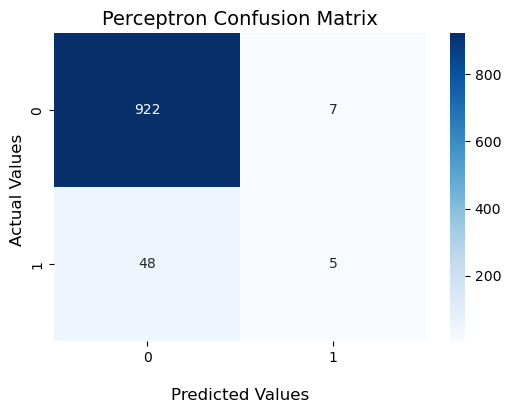

In [13]:
y_pred = per_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("Perceptron Confusion Matrix", fontsize = 14)
plt.show()

## Model 2: Logistic Regression

There doesn't appear to be an option to change parameters to train a logistic regression model using scikit-learn, so I'll just move forwards with the default.

#### Performance/Error Analysis

In [14]:
log_model = LogisticRegression(random_state = 42)
log_model.fit(X_train, y_train)
print("Training accuracy:", log_model.score(X_train, y_train))
print("Testing accuracy:", log_model.score(X_test, y_test))

Training accuracy: 0.9605296664120193
Testing accuracy: 0.9460285132382892


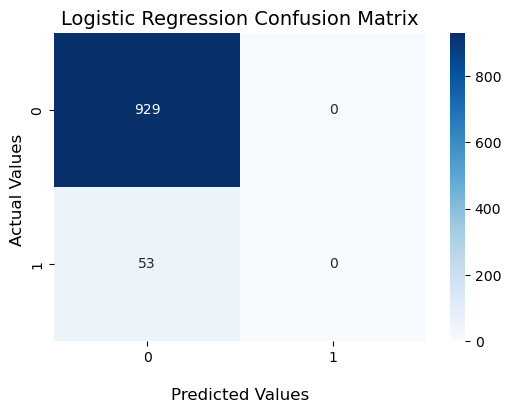

In [15]:
y_pred = log_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("Logistic Regression Confusion Matrix", fontsize = 14)
plt.show()

## Model 3: Dense Neural Networks (Multilayer Perceptron)

#### Finding the best model under different learning rates

In [16]:
for lr in learning_rates:
    mlp_model = MLPClassifier(learning_rate_init = lr, max_iter = 500, random_state = 42)
    mlp_model.fit(X_train, y_train)
    print(f"rate = {lr}: {mlp_model.score(X_train, y_train)} with {mlp_model.n_layers_} layers")

rate = 0.8: 0.9602750190985485 with 3 layers
rate = 0.5: 0.9602750190985485 with 3 layers
rate = 0.25: 0.9602750190985485 with 3 layers
rate = 0.1: 0.9602750190985485 with 3 layers
rate = 0.01: 0.9602750190985485 with 3 layers
rate = 0.001: 0.9582378405907818 with 3 layers
rate = 0.0001: 0.959511077158136 with 3 layers
rate = 1e-05: 0.9592564298446652 with 3 layers


In [17]:
mlp_model = MLPClassifier(learning_rate_init = 0.01, max_iter = 500, random_state = 42)
mlp_model.fit(X_train, y_train)

print("Training accuracy:", mlp_model.score(X_train, y_train))
print("Testing accuracy:", mlp_model.score(X_test, y_test))

Training accuracy: 0.9602750190985485
Testing accuracy: 0.9460285132382892


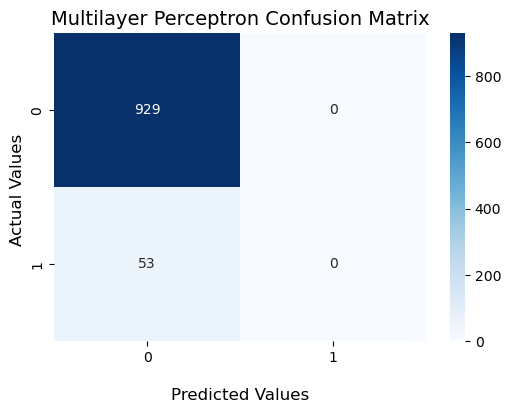

In [18]:
y_pred = mlp_model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("Multilayer Perceptron Confusion Matrix", fontsize = 14)
plt.show()

## Model 4: *k*-Nearest Neighbors

#### Finding the optimal k

In [19]:
knn_accuracy = []
#possible_k = range(3, int(np.ceil(np.sqrt(X_train.shape[0]))))
possible_k = range(3, 16)
for k in possible_k:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    knn_accuracy.append(knn.score(X_train, y_train))

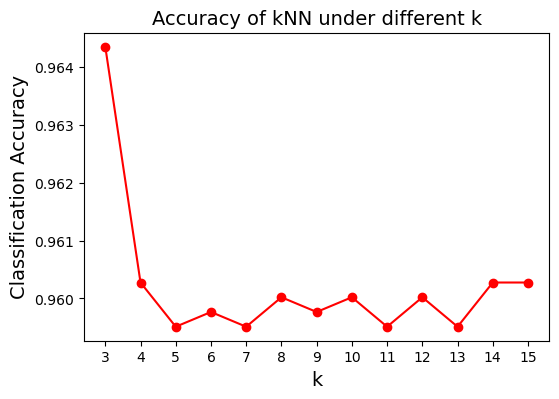

In [20]:
plt.figure(figsize = (6, 4))
plt.plot(possible_k, knn_accuracy, color = 'red', marker = "o")
plt.title("Accuracy of kNN under different k", fontsize = 14)
plt.xlabel('k', fontsize = 14)
plt.ylabel('Classification Accuracy', fontsize = 14)
plt.xticks(possible_k)
plt.show()

The classification accuracy is highest when k = 3, so that is what I will proceed with.

#### Performance/Error Analysis

In [21]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

print("Training accuracy:", knn.score(X_train, y_train))
print("Testing accuracy:", knn.score(X_test, y_test))

Training accuracy: 0.964349376114082
Testing accuracy: 0.9348268839103869


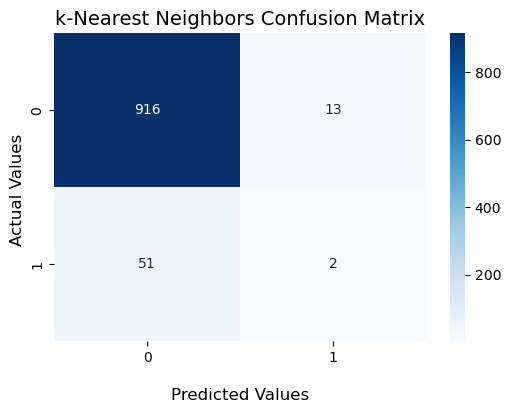

In [22]:
y_pred = knn.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("k-Nearest Neighbors Confusion Matrix", fontsize = 14)
plt.show()

## Model 5: Decision Trees

#### Finding the optimal k

In [23]:
tree_accuracy = []
possible_depth = range(2, 21)
for d in possible_depth:
    decision_tree = DecisionTreeClassifier(max_depth = d, random_state = 42)
    decision_tree.fit(X_train, y_train)
    tree_accuracy.append(decision_tree.score(X_train, y_train))

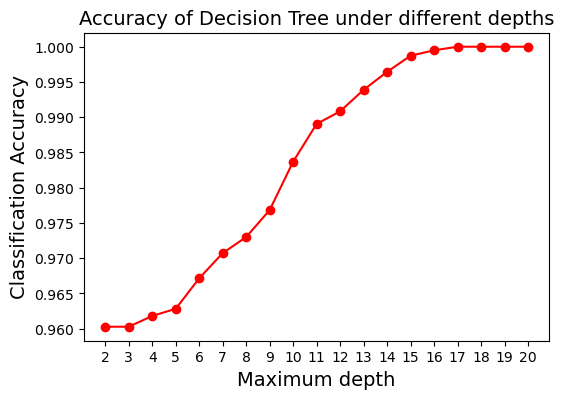

In [24]:
plt.figure(figsize = (6, 4))
plt.plot(possible_depth, tree_accuracy, color = 'red', marker = "o")
plt.title("Accuracy of Decision Tree under different depths", fontsize = 14)
plt.xlabel('Maximum depth', fontsize = 14)
plt.ylabel('Classification Accuracy', fontsize = 14)
plt.xticks(possible_depth)
plt.show()

To maximize accuracy, the maximum depth of the tree should be 17. Anything beyond 17 would be overfitting without a significant gain in accuracy.

Actually, even at `max_depth=11` there is 99% training accuracy. And `max_depth=2` already has 96% training accuracy as well. I will explore all three potential models and see if the increase in complexity is worth it.

#### Performance/Error Analysis (max_depth=17)

In [25]:
decision_tree17 = DecisionTreeClassifier(max_depth = 17, random_state = 42)
decision_tree17.fit(X_train, y_train)

# from sklearn.tree import plot_tree
# Would be good to display the actual tree but this one is too large

print("Training accuracy:", decision_tree17.score(X_train, y_train))
print("Testing accuracy:", decision_tree17.score(X_test, y_test))

Training accuracy: 1.0
Testing accuracy: 0.9124236252545825


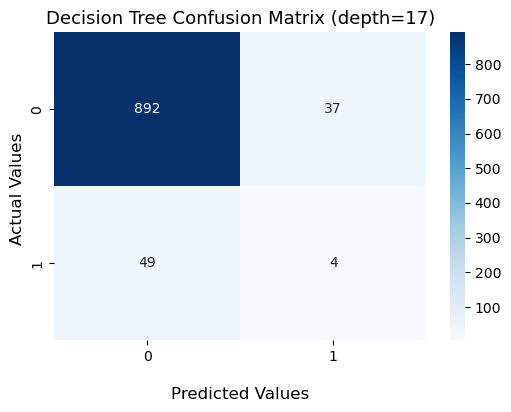

In [26]:
y_pred = decision_tree17.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("Decision Tree Confusion Matrix (depth=17)", fontsize = 13)
plt.show()

In [27]:
print_bias_variance(decision_tree17, X_train, y_train, X_test, y_test)

MSE: 0.089
Bias: 0.050
Variance: 0.039


#### Performance/Error Analysis (max_depth=11)

In [28]:
decision_tree11 = DecisionTreeClassifier(max_depth = 11, random_state = 42)
decision_tree11.fit(X_train, y_train)

print("Training accuracy:", decision_tree11.score(X_train, y_train))
print("Testing accuracy:", decision_tree11.score(X_test, y_test))

Training accuracy: 0.9890501655207538
Testing accuracy: 0.9215885947046843


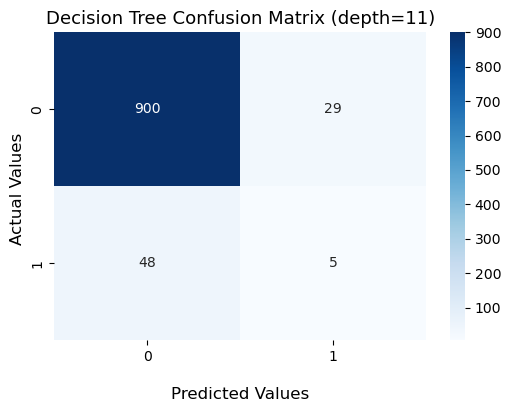

In [29]:
y_pred = decision_tree11.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("Decision Tree Confusion Matrix (depth=11)", fontsize = 13)
plt.show()

In [30]:
print_bias_variance(decision_tree11, X_train, y_train, X_test, y_test)

MSE: 0.084
Bias: 0.049
Variance: 0.035


#### Performance/Error Analysis (max_depth=2)

In [31]:
decision_tree2 = DecisionTreeClassifier(max_depth = 2, random_state = 42)
decision_tree2.fit(X_train, y_train)

print("Training accuracy:", decision_tree2.score(X_train, y_train))
print("Testing accuracy:", decision_tree2.score(X_test, y_test))

Training accuracy: 0.9602750190985485
Testing accuracy: 0.9460285132382892


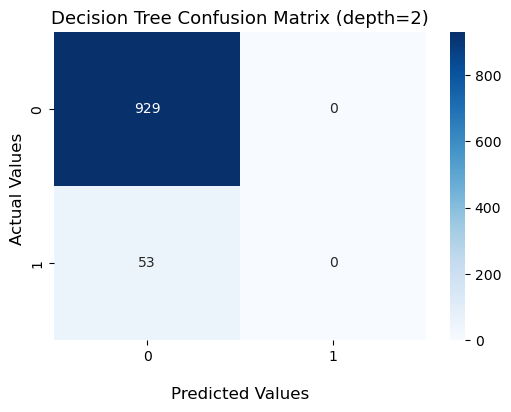

In [32]:
y_pred = decision_tree2.predict(X_test)
plot_confusion_matrix(y_test, y_pred)
plt.title("Decision Tree Confusion Matrix (depth=2)", fontsize = 13)
plt.show()

In [33]:
print_bias_variance(decision_tree2, X_train, y_train, X_test, y_test)

MSE: 0.055
Bias: 0.054
Variance: 0.001


#### The Best Decision Tree

A model with high bias and low variance may underfit the data, while a model with low bias and high variance may overfit the data.

It's obvious that at `max_depth=2`, underfitting is occurring. Between `max_depth=11` and `max_depth=17`, it is a bit of a hard call - the bias and variance are fairly similar. However, I will argue that `max_depth=11` produces the best decision tree for this data because it does have lower variance without too much change in bias. Furthermore, at `max_depth=17`, the training accuracy is 100%, signaling there is truly overfitting. In fact, at `max_depth=11`, the testing accuracy is higher, by 1% too.

| Metric      | max_depth=17 | max_depth=11 | max_depth=2 |
| ----------- | ------------ | ------------ | ----------- |
| Training Accuracy| 100.00% | 98.91% | 96.03% |
| Testing Accuracy |  91.24% | 92.16% | 94.60% |
| Bias             |  0.050 |  0.049 | 0.054 |
| Variance         |  0.039 |  0.035 | 0.001 |

It would be good to explore other `max_depth`s between 2 and 11, but I will leave it there.

## Model 6: Ensemble Methods

## Conclusion

Recall that blindly guessing 0 has a testing accuracy of 94.60%. Ideally the best model will have a high accuracy, but also since we want to successfully correctly guess the occurrence of a stroke, we want to surpass this metric.

Specifically, we want a low type II error. It is much more dangerous to diagnose someone as not having a stroke.

In [34]:
# Metrics for model where you just blindly guess zero for all predictions
print(f"Training accuracy: {accuracy_score(y_train, np.zeros(y_train.shape))}")
print(f"Testing accuracy: {accuracy_score(y_test, np.zeros(y_test.shape))}")

Training accuracy: 0.9602750190985485
Testing accuracy: 0.9460285132382892


| Model       | Training Accuracy | Testing Accuracy |
| ----------- | ----------------- | ---------------- |
| Blindly guess 0 | 96.03% | 94.60% |
| Perceptron | 94.98% | 94.40% |
| Logistic Regression | 96.05% | 94.60% |
| kNN $(k=3)$ | 96.43% | 93.48% |
| Decision Tree (`max_depth=11`) |98.91% | 91.24% |